
## **Objectif du Projet**

L'objectif principal est de **reconstruire (ou inférer) la structure graphique (les liens)** d'un modèle probabiliste (ici, un réseau bayésien) à partir de données, puis d'évaluer la qualité de cette reconstruction.

### **1. Reconstruction du Réseau (Inférence)**

Nous utilisererons des données (le jeu de données `insurance` de `bnlearn`) pour déterminer **quels nœuds sont connectés** et, potentiellement, **la direction des liens**.

### **2. Comparaison des Méthodes**

Nous devons appliquer et comparer **différentes familles d'algorithmes** de reconstruction (`hill-climbing`, `PC`, `ARACNE`, etc.) pour voir quelle approche fonctionne le mieux sur ce jeu de données spécifique.

### **3. Évaluation de la Performance**

Puisque le modèle `insurance` est un **modèle de vérité terrain** (*ground truth*), nous savons exactement où se trouvent les vrais liens. Nous utiliserons cette vérité pour évaluer la qualité de chaque réseau reconstruit en calculant des métriques standards comme la **Précision** et le **Rappel**.

# **Étape 0 : Préparation et Référence (Vérité Terrain)**

L'objectif de cette étape est de préparer l'environnement de travail et d'établir la base de comparaison inaltérable (le ground truth ou la vérité terrain) pour l'évaluation de tous les réseaux que vous allez reconstruire.

## **0.1. Installation et Chargement des Packages**

In [ ]:
# Installation des packages
install.packages("bnlearn")
install.packages("igraph")
#install.packages("pcalg")
install.packages("miic")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Installe le package nécessaire pour gérer les packages Bioconductor
install.packages("BiocManager")

# Charge la librairie
library(BiocManager)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Installe les dépendances Bioconductor (graph et RBGL)
BiocManager::install(c("graph", "RBGL", "ggm"), update = FALSE, ask = FALSE)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'graph', 'RBGL', 'ggm'

also installing the dependency ‘BiocGenerics’




In [ ]:
# Installe le package pcalg
install.packages("pcalg")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Chargement des librairies R nécessaires
library(bnlearn)
library(igraph)
library(miic)
library(pcalg)


Attaching package: ‘pcalg’


The following objects are masked from ‘package:bnlearn’:

    dsep, pdag2dag, shd, skeleton




## **0.2. Chargement des Données et du Modèle de Référence**

le ground_truth_model (ou modèle de vérité terrain) sert de référence absolue et connue pour l'évaluation de nos algorithmes de reconstruction.

C'est le réseau idéal et parfait que les auteurs du jeu de données insurance ont défini. Il représente les vrais liens de cause à effet qui existent dans le système d'assurance qu'ils ont modélisé.

In [ ]:
# 1. Chargement du jeu de données (les observations)
data(insurance)

# 2. Le modèle de vérité terrain (la structure connue)
# La structure du réseau bayésien (arcs)
# La chaîne utilisée pour la vérité terrain (G)

#ground_truth_model <- model2network("[Age][SocioEcon][RiskAversion|Age][SeniorTrain|Age][DrivingSkill|Age][OtherCar|SocioEcon][GoodStudent|Age:SocioEcon][DrivHist|Age:SocioEcon:DrivingSkill][Antitheft|OtherCar:RiskAversion][HomeBase|OtherCar:RiskAversion][MakeModel|Antitheft:HomeBase][VehicleYear|Antitheft:HomeBase][Mileage|MakeModel:VehicleYear][DrivQuality|MakeModel:VehicleYear][Airbag|Mileage:DrivQuality][Antilock|Mileage:DrivQuality][Rugged|Airbag:Antilock][Auto|Airbag:Antilock][CarValue|Rugged:Auto][Cushioning|CarValue][Accident|CarValue:Cushioning][MedCost|Accident][ILiCost|Accident][OtherCarCost|Accident][ThisCarDam|Accident][ThisCarCost|Accident][Theft|CarValue:Accident]")
ground_truth_model <- model2network(paste0("[Age][Mileage][SocioEcon|Age][GoodStudent|Age:SocioEcon]",
  "[RiskAversion|Age:SocioEcon][OtherCar|SocioEcon][VehicleYear|SocioEcon:RiskAversion]",
  "[MakeModel|SocioEcon:RiskAversion][SeniorTrain|Age:RiskAversion]",
  "[HomeBase|SocioEcon:RiskAversion][AntiTheft|SocioEcon:RiskAversion]",
  "[RuggedAuto|VehicleYear:MakeModel][Antilock|VehicleYear:MakeModel]",
  "[DrivingSkill|Age:SeniorTrain][CarValue|VehicleYear:MakeModel:Mileage]",
  "[Airbag|VehicleYear:MakeModel][DrivQuality|RiskAversion:DrivingSkill]",
  "[Theft|CarValue:HomeBase:AntiTheft][Cushioning|RuggedAuto:Airbag]",
  "[DrivHist|RiskAversion:DrivingSkill][Accident|DrivQuality:Mileage:Antilock]",
  "[ThisCarDam|RuggedAuto:Accident][OtherCarCost|RuggedAuto:Accident]",
  "[MedCost|Age:Accident:Cushioning][ILiCost|Accident]",
  "[ThisCarCost|ThisCarDam:Theft:CarValue][PropCost|ThisCarCost:OtherCarCost]"))

## **0.3. Vérification et Inspection du Modèle**

S'assurer que l'objet créé est valide (classe bn) et vérifier ses dimensions (nombre de nœuds et d'arcs).

In [ ]:
# Vérification de la classe de l'objet
cat("Classe de l'objet de vérité terrain :", class(ground_truth_model), "\n")


# Affichage du contenu : donne le nombre de nœuds et d'arcs
cat("--- Contenu du Modèle de Vérité Terrain ---\n")
print(ground_truth_model)

Classe de l'objet de vérité terrain : bn 
--- Contenu du Modèle de Vérité Terrain ---

  Random/Generated Bayesian network

  model:
   [Age][Mileage][SocioEcon|Age][GoodStudent|Age:SocioEcon][OtherCar|SocioEcon]
   [RiskAversion|Age:SocioEcon][AntiTheft|RiskAversion:SocioEcon]
   [HomeBase|RiskAversion:SocioEcon][MakeModel|RiskAversion:SocioEcon]
   [SeniorTrain|Age:RiskAversion][VehicleYear|RiskAversion:SocioEcon]
   [Airbag|MakeModel:VehicleYear][Antilock|MakeModel:VehicleYear]
   [CarValue|MakeModel:Mileage:VehicleYear][DrivingSkill|Age:SeniorTrain]
   [RuggedAuto|MakeModel:VehicleYear][Cushioning|Airbag:RuggedAuto]
   [DrivHist|DrivingSkill:RiskAversion][DrivQuality|DrivingSkill:RiskAversion]
   [Theft|AntiTheft:CarValue:HomeBase][Accident|Antilock:DrivQuality:Mileage]
   [ILiCost|Accident][MedCost|Accident:Age:Cushioning]
   [OtherCarCost|Accident:RuggedAuto][ThisCarDam|Accident:RuggedAuto]
   [ThisCarCost|CarValue:Theft:ThisCarDam][PropCost|OtherCarCost:ThisCarCost]
  nodes:    

## **0.4. Obtention de la Matrice d'Adjacence (Matrice $G$)**

Transformer la structure symbolique (bn object) en une matrice numérique G (matrice d'adjacence dirigée, 29x29), nécessaire pour la construction igraph et les calculs d'évaluation.

In [ ]:
# Utilise bnlearn::amat pour obtenir la matrice d'adjacence G
# G[i, j] = 1 si il y a un arc i -> j, et 0 sinon.
G_directed_matrix <- bnlearn::amat(ground_truth_model)

# Vérification des dimensions
cat("\nDimensions de la matrice d'adjacence G :", paste(dim(G_directed_matrix), collapse = "x"), "\n")


Dimensions de la matrice d'adjacence G : 27x27 


## **0.5. Construction du Graphe igraph et Visualisation**

Construire l'objet igraph dirigé Gigraph​ à partir de la matrice G et le visualiser avec une mise en page claire pour servir de référence visuelle.

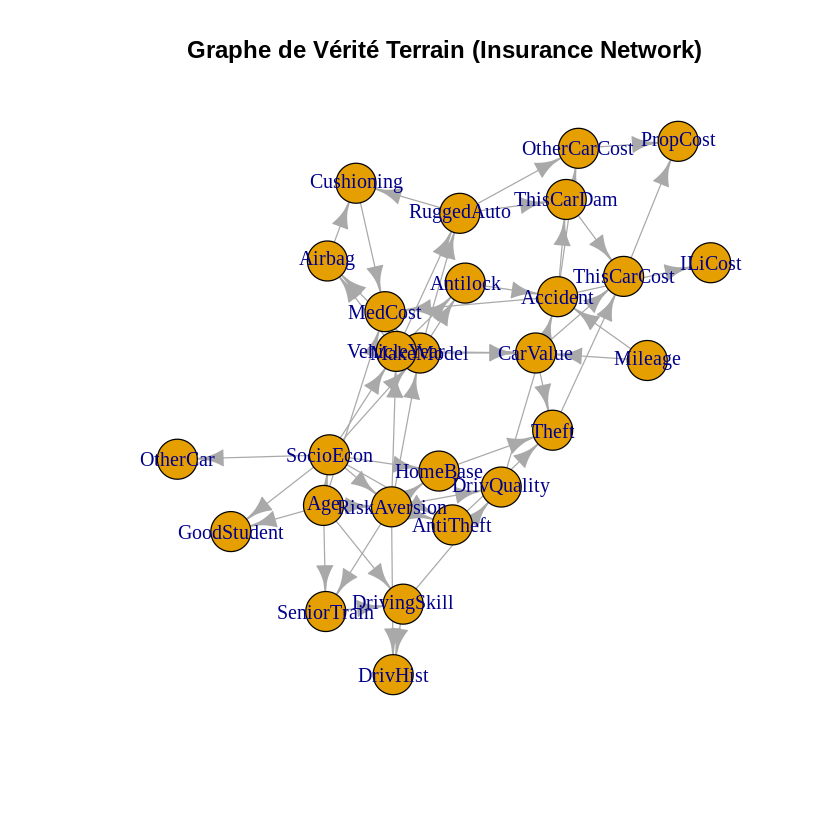

In [ ]:
# 1. Construction du graphe igraph dirigé
G_igraph <- graph_from_adjacency_matrix(G_directed_matrix,
                                        mode = "directed", # Indique que les arcs sont orientés
                                        diag = FALSE)      # Ignore la diagonale (pas de boucles)

# 2. Personnalisation des attributs de visualisation (pour un affichage 'nice')
V(G_igraph)$label <- V(G_igraph)$name     # Utiliser les noms des nœuds comme étiquettes
V(G_igraph)$size <- 15                  # Taille des nœuds
V(G_igraph)$label.cex <- 1             # Taille des étiquettes (labels)
E(G_igraph)$color <- "darkgrey"          # Couleur des arêtes
E(G_igraph)$arrow.size <- 1            # Taille des pointes de flèches

# 3. Choix de la mise en page (Layout)
# L'algorithme Fruchterman-Reingold (fr) est souvent utilisé pour une bonne séparation des clusters
layout_plot <- layout_with_fr(G_igraph)

# 4. Affichage du graphe de référence
plot(G_igraph,
     layout = layout_plot,
     main = "Graphe de Vérité Terrain (Insurance Network)")

# **Étape 1 : Reconstruction par Méthode Basée sur le Score (hill-climbing)**

Cette étape utilise la méthode Hill-Climbing (hc), un algorithme glouton basé sur le score, pour inférer la structure du réseau bayésien. L'objectif est de trouver la structure d'arcs qui maximise un score de qualité (par défaut, le BIC) sur le jeu de données insurance.

## **1.1. Chargement des Données**

In [ ]:
# La fonction 'data()' charge le jeu de données 'insurance' (qui est inclus dans le package bnlearn)
# dans l'environnement de travail R sous forme de dataframe.
data(insurance)

In [ ]:
# Afficher la structure du dataframe (structure) pour voir le type des variables (facteur, numérique, etc.)
# et confirmer le nombre de variables (colonnes).
cat("--- Structure du jeu de données 'insurance' ---\n")
print(str(insurance))

--- Structure du jeu de données 'insurance' ---
'data.frame':	20000 obs. of  27 variables:
 $ GoodStudent : Factor w/ 2 levels "False","True": 1 1 1 1 1 1 1 1 1 2 ...
 $ Age         : Factor w/ 3 levels "Adolescent","Adult",..: 2 3 3 1 1 2 3 2 2 1 ...
 $ SocioEcon   : Factor w/ 4 levels "Middle","Prole",..: 2 2 3 1 2 3 3 2 2 2 ...
 $ RiskAversion: Factor w/ 4 levels "Adventurous",..: 1 2 4 3 3 3 3 3 3 2 ...
 $ VehicleYear : Factor w/ 2 levels "Current","Older": 2 1 1 2 2 1 1 2 2 2 ...
 $ ThisCarDam  : Factor w/ 4 levels "Mild","Moderate",..: 2 3 3 3 2 2 1 4 4 4 ...
 $ RuggedAuto  : Factor w/ 3 levels "EggShell","Football",..: 1 2 2 1 2 1 2 1 1 2 ...
 $ Accident    : Factor w/ 4 levels "Mild","Moderate",..: 1 3 3 3 2 2 1 4 4 4 ...
 $ MakeModel   : Factor w/ 5 levels "Economy","FamilySedan",..: 1 1 2 1 1 4 1 1 1 2 ...
 $ DrivQuality : Factor w/ 3 levels "Excellent","Normal",..: 3 2 1 2 3 3 3 3 3 3 ...
 $ Mileage     : Factor w/ 4 levels "Domino","FiftyThou",..: 4 4 1 2 2 2 3 4 4 4 ...
 $

In [ ]:
# Afficher les premières lignes des données (head) pour un aperçu visuel
cat("\n--- Aperçu des premières lignes ---\n")
head(insurance)


--- Aperçu des premières lignes ---


,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,Accident,MakeModel,DrivQuality,⋯,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag,ILiCost,DrivHist
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,False,Adult,Prole,Adventurous,Older,Moderate,EggShell,Mild,Economy,Poor,⋯,City,False,TenThou,Thousand,True,Thousand,Poor,False,Thousand,Many
2,False,Senior,Prole,Cautious,Current,None,Football,None,Economy,Normal,⋯,City,True,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero
3,False,Senior,UpperMiddle,Psychopath,Current,None,Football,None,FamilySedan,Excellent,⋯,City,False,Thousand,Thousand,False,Thousand,Good,True,Thousand,One
4,False,Adolescent,Middle,Normal,Older,None,EggShell,None,Economy,Normal,⋯,Suburb,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Zero
5,False,Adolescent,Prole,Normal,Older,Moderate,Football,Moderate,Economy,Poor,⋯,City,False,TenThou,Thousand,False,Thousand,Fair,False,Thousand,Many
6,False,Adult,UpperMiddle,Normal,Current,Moderate,EggShell,Moderate,SportsCar,Poor,⋯,Suburb,True,HundredThou,HundredThou,True,TenThou,Poor,True,Thousand,Many


## **1.2. Reconstruction du réseau d'Insurance et Vérification**

Appliquer l'algorithme Hill-Climbing (hc) sur les données insurance pour obtenir la première structure de réseau reconstruite (RHC​). Ensuite, vérifier le type et le contenu de l'objet résultant.

In [ ]:
# Il utilise par défaut le score BIC pour évaluer les structures testées.
# Le résultat R_hc_model est un objet 'bn' (Bayesian Network).
R_hc_model <- bnlearn::hc(insurance)

# Vérification de la classe de l'objet retourné (doit être 'bn')
cat("Classe de l'objet reconstruit par HC :", class(R_hc_model), "\n")

# Inspection du contenu : affiche le nombre de nœuds (27) et le nombre d'arcs dirigés
# que l'algorithme a inféré à partir des données.
cat("--- Contenu du Modèle Reconstruit (HC) ---\n")
print(R_hc_model)

Classe de l'objet reconstruit par HC : bn 
--- Contenu du Modèle Reconstruit (HC) ---

  Bayesian network learned via Score-based methods

  model:
   [RuggedAuto][MakeModel|RuggedAuto][CarValue|RuggedAuto:MakeModel]
   [Mileage|CarValue][VehicleYear|MakeModel:Mileage:CarValue]
   [SocioEcon|VehicleYear:MakeModel][Antilock|VehicleYear:MakeModel]
   [Airbag|VehicleYear:MakeModel][ThisCarDam|Mileage:Antilock]
   [OtherCar|SocioEcon][Cushioning|RuggedAuto:Airbag]
   [Accident|ThisCarDam:RuggedAuto][ThisCarCost|ThisCarDam:CarValue]
   [MedCost|ThisCarDam:Cushioning][DrivQuality|Accident:Mileage]
   [Theft|ThisCarDam:ThisCarCost][OtherCarCost|RuggedAuto:Accident]
   [ILiCost|Accident][Age|SocioEcon:DrivQuality]
   [PropCost|ThisCarCost:OtherCarCost][GoodStudent|Age:SocioEcon]
   [SeniorTrain|Age:DrivQuality][RiskAversion|Age:DrivQuality:SeniorTrain]
   [DrivingSkill|RiskAversion:DrivQuality][HomeBase|SocioEcon:RiskAversion]
   [AntiTheft|SocioEcon:RiskAversion][DrivHist|RiskAversion:Driving

**1.3. Obtention de la Matrice d'Adjacence $R_{HC}$**

Obtenir la matrice d'adjacence dirigée RHC​ (27x27) du réseau reconstruit par Hill-Climbing.

In [ ]:
# Utilise bnlearn::amat sur l'objet bn de la reconstruction HC (R_hc_model)
# R_hc_directed_matrix[i, j] = 1 si l'arc dirigé i -> j existe dans la reconstruction HC.
R_hc_directed_matrix <- bnlearn::amat(R_hc_model)

# Affichage des dimensions de la matrice (doit être 27x27)
cat("Dimensions de la Matrice Dirigée R_HC :", paste(dim(R_hc_directed_matrix), collapse = "x"), "\n")

Dimensions de la Matrice Dirigée R_HC : 27x27 


## **Standardisation des Noms de Nœuds**

nous allons nous assurer que les matrices $G$ et $R_{HC}$ ont exactement les mêmes noms de colonnes et dans le même ordre.

 Récupérer l'Ordre de $R_{HC}$ (qui utilise les noms de insurance)

 L'objet $R_{HC}$ utilise l'ordre et les noms des variables du dataframe insurance. Nous allons forcer $G$ à utiliser cet ordre.

In [ ]:
# 1. Obtenir la liste ordonnée des noms de nœuds de la reconstruction HC
HC_nodes_order <- bnlearn::nodes(R_hc_model)

# 2. Ré-établir G_directed_matrix avec l'ordre de HC
G_directed_matrix <- bnlearn::amat(ground_truth_model)
G_directed_matrix <- G_directed_matrix[HC_nodes_order, HC_nodes_order]

# Vérification (doit être TRUE si les noms correspondent)
cat("Les noms des nœuds correspondent-ils :", all(colnames(G_directed_matrix) == HC_nodes_order), "\n")

Les noms des nœuds correspondent-ils : TRUE 


## **1.4. Construction du Graphe igraph et Visualisation**

Construire l'objet igraph dirigé du réseau reconstruit par Hill-Climbing et le tracer, en utilisant le même layout que pour la vérité terrain (Étape 0) pour faciliter la comparaison visuelle.

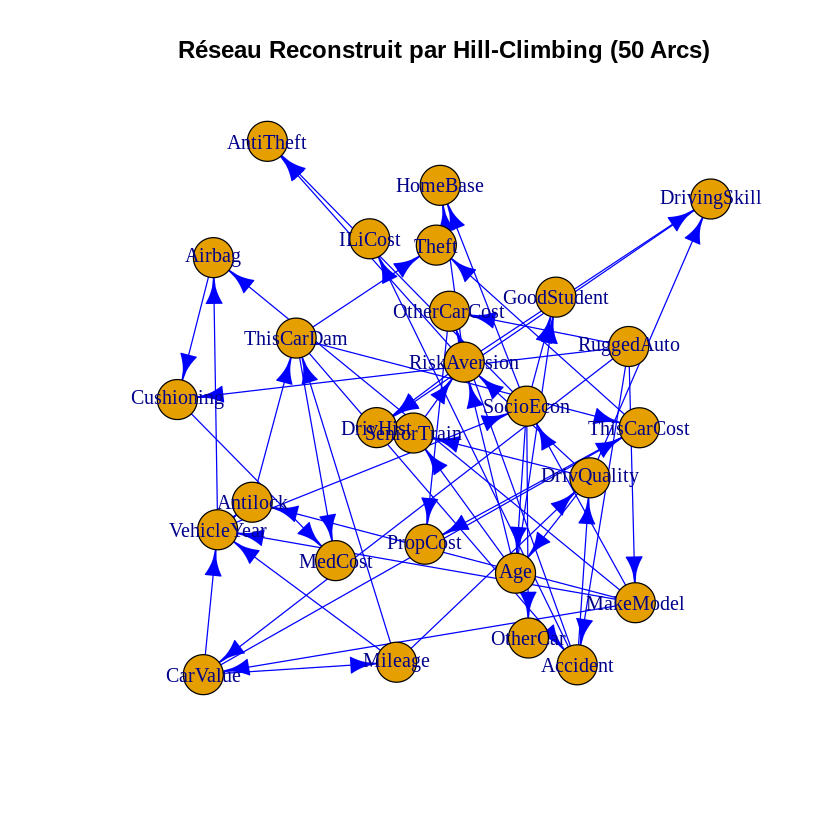

In [ ]:
# 1. Construction du graphe igraph dirigé
R_hc_igraph <- graph_from_adjacency_matrix(R_hc_directed_matrix,
                                           mode = "directed", # Indique les arcs dirigés
                                           diag = FALSE)

# 2. Paramètres de visualisation (Identiques à G pour une bonne comparaison)
V(R_hc_igraph)$label <- V(R_hc_igraph)$name
V(R_hc_igraph)$size <- 15
V(R_hc_igraph)$label.cex <- 1
E(R_hc_igraph)$color <- "blue"
E(R_hc_igraph)$arrow.size <- 1

# 3. Affichage du graphe
plot(R_hc_igraph,
     layout = layout_plot,
     main = "Réseau Reconstruit par Hill-Climbing (50 Arcs)")

**1.5. Calcul des Métriques**

Compter les Vrais Positifs (TP), Faux Positifs (FP) et Faux Négatifs (FN) en comparant le squelette de RHC​ au squelette de la vérité terrain (Gskel​). Puis, calculer la Précision, le Rappel et le F-score.

In [ ]:
# --- Préparation des Squelettes (Matrice Non-Orientée) ---

# 1. Création du Squelette de la Vérité Terrain (G_skel) - Référence 27x27 (52 arcs -> 46 liens)
# Nous utilisons la matrice dirigée G_directed_matrix (52 arcs) de l'Étape 0.

# Le squelette G_skel est la matrice booléenne où G_skel[i,j]=1 si i--j existe,
# ignorant la direction, et G_skel[i,i]=0.
G_skel <- G_directed_matrix | t(G_directed_matrix) # Opération OU logique
diag(G_skel) <- 0 # S'assurer que la diagonale est à zéro
G_skel <- as.numeric(G_skel) # Convertir en numérique (0 ou 1)
dim(G_skel) <- dim(G_directed_matrix) # Garder les dimensions originales

# 2. Création du Squelette de la Reconstruction (R_hc_skel)
R_hc_skel <- R_hc_directed_matrix | t(R_hc_directed_matrix)
diag(R_hc_skel) <- 0
R_hc_skel <- as.numeric(R_hc_skel)
dim(R_hc_skel) <- dim(R_hc_directed_matrix)

# Total de liens dans le squelette de la Vérité Terrain (doit être 46)
Total_liens_GT <- sum(G_skel[upper.tri(G_skel)])
cat(sprintf("Nombre de liens non-orientés dans GT (G_skel) : %d\n", Total_liens_GT))

# --- Calcul de la Matrice de Confusion et des Métriques ---

# On utilise la partie supérieure triangulaire pour comparer les paires de nœuds sans doublons.
GT_edges <- G_skel[upper.tri(G_skel)] # Les 351 positions possibles des liens
HC_edges <- R_hc_skel[upper.tri(R_hc_skel)]

# Vrais Positifs (TP) : Liens trouvés par HC qui existent dans GT
TP <- sum(GT_edges == 1 & HC_edges == 1)

# Faux Positifs (FP) : Liens trouvés par HC qui N'existent PAS dans GT (Erreurs de Type I)
FP <- sum(GT_edges == 0 & HC_edges == 1)

# Faux Négatifs (FN) : Liens Manquants. Existent dans GT mais PAS dans HC (Erreurs de Type II)
FN <- sum(GT_edges == 1 & HC_edges == 0)

# Calcul des métriques
Precision <- TP / (TP + FP)
Recall <- TP / (TP + FN)
Fscore <- 2 * (Precision * Recall) / (Precision + Recall)

# Affichage des résultats
cat("\n--- Évaluation Hill-Climbing (Squelette) ---\n")
cat(sprintf("Vrais Positifs (TP): %d\n", TP))
cat(sprintf("Faux Positifs (FP): %d\n", FP))
cat(sprintf("Faux Négatifs (FN): %d\n", FN))
cat(sprintf("Liens GT (TP + FN): %d\n", TP + FN))
cat(sprintf("Liens HC (TP + FP): %d\n", TP + FP))
cat("--------------------------------------------\n")
cat(sprintf("Précision (Precision) : %.4f\n", Precision))
cat(sprintf("Rappel (Recall) : %.4f\n", Recall))
cat(sprintf("F-score (F1) : %.4f\n", Fscore))

Nombre de liens non-orientés dans GT (G_skel) : 52

--- Évaluation Hill-Climbing (Squelette) ---
Vrais Positifs (TP): 38
Faux Positifs (FP): 12
Faux Négatifs (FN): 14
Liens GT (TP + FN): 52
Liens HC (TP + FP): 50
--------------------------------------------
Précision (Precision) : 0.7600
Rappel (Recall) : 0.7308
F-score (F1) : 0.7451


## **Interprétation des Résultats Hill-Climbing (Squelette)**

### 1\. Matrice de Confusion (Comptage des Arcs)

| Catégorie | Valeur | Interprétation |
| :--- | :--- | :--- |
| **Vrais Positifs (TP)** | **38** | Le modèle HC a correctement identifié l'existence de **38** liens non-orientés qui existent réellement dans le réseau de vérité terrain ($G$). |
| **Faux Positifs (FP)** | **12** | Le modèle HC a identifié **12** liens qui n'existent *pas* dans la vérité terrain. Ce sont des liens erronés créés par l'algorithme (Erreur de Type I). |
| **Faux Négatifs (FN)** | **14** | Le modèle HC a *omis* de trouver **14** liens qui existent pourtant dans la vérité terrain. Ce sont des liens manquants (Erreur de Type II). |
| **Liens GT (TP + FN)** | **52** | C'est le nombre total de liens non-orientés dans la vérité terrain ($G$). (52 arcs dirigés se sont traduits par 52 liens non-orientés, ce qui est normal si aucun arc n'est bidirectionnel). |
| **Liens HC (TP + FP)** | **50** | C'est le nombre total de liens non-orientés trouvés par l'algorithme HC. |



### 2\. Métriques de Performance

Les scores sont calculés à partir du comptage ci-dessus et évaluent la qualité de la reconstruction.

| Métrique | Valeur | Formule | Interprétation |
| :--- | :--- | :--- | :--- |
| **Précision** | **$0.7600$ (76%)** | $\frac{TP}{TP + FP} = \frac{38}{38 + 12}$ | Sur tous les liens **trouvés** par Hill-Climbing (50), **76%** étaient corrects. C'est la capacité du modèle à ne pas faire d'erreurs d'inclusion. |
| **Rappel** | **$0.7308$ (73%)** | $\frac{TP}{TP + FN} = \frac{38}{38 + 14}$ | Sur tous les liens **réels** du réseau ($52$), **73%** ont été correctement identifiés. C'est la capacité du modèle à ne pas oublier de liens (exhaustivité). |
| **F-score (F1)** | **$0.7451$ (74.51%)** | $2 \cdot \frac{Précision \cdot Rappel}{Précision + Rappel}$ | C'est la moyenne harmonique entre la Précision et le Rappel. Un score élevé (au-dessus de 0.7) indique un bon équilibre entre la capacité du modèle à éviter les fausses inclusions et à retrouver la majorité des liens. |

**Conclusion pour l'évaluation du squelette :** L'algorithme Hill-Climbing a produit un très bon résultat. Il a réussi à identifier près des trois quarts de la structure du réseau, avec un taux de fausses inclusions (FP) et de liens manqués (FN) raisonnable.

**1.6. Mise en évidence des FP**

Nous allons visualiser le réseau $R_{HC}$ en utilisant le même layout que précédemment, mais en colorant les Faux Positifs (FP) en rouge, et les Vrais Positifs (TP) en bleu (ou vert).

Warning message:
“`get.edge.ids()` was deprecated in igraph 2.1.0.
ℹ Please use `get_edge_ids()` instead.”


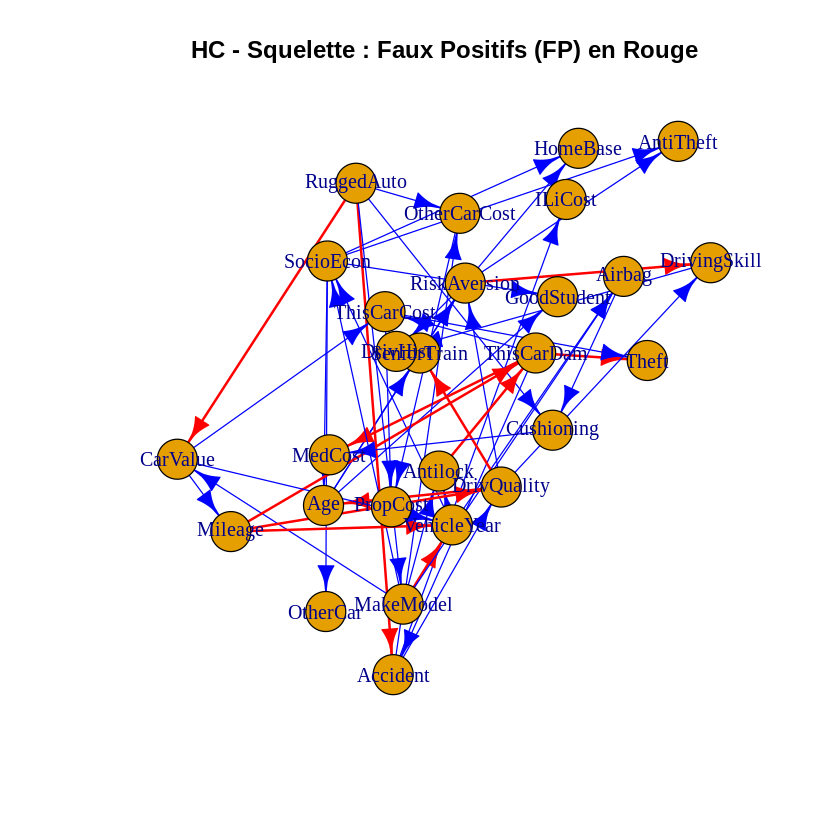

In [ ]:
# 2.f. Highlight the FP edges in your reconstructed network.

# 1. Identifier les indices des arcs FP (utilisez la partie triangulaire supérieure)
# Les FP sont les liens où G_edges == 0 (absence dans GT) et HC_edges == 1 (présence dans HC)
FP_indices <- which(GT_edges == 0 & HC_edges == 1)

# 2. Créer un vecteur de couleurs pour tous les arcs de R_hc_igraph
edge_colors <- rep("blue", ecount(R_hc_igraph)) # Initialiser tous les arcs trouvés en bleu (TP/FP)
edge_widths <- rep(1, ecount(R_hc_igraph))

# 3. Trouver les arcs réels correspondants dans R_hc_igraph à partir de la matrice
# La fonction 'get.edgelist' donne les paires d'arcs dans l'ordre de la matrice.

# Créer une liste d'arêtes qui sont des Faux Positifs (FP)
FP_edges <- R_hc_skel * (1 - G_skel) # Matrice qui est 1 seulement aux positions FP

# Convertir la matrice FP en liste d'arêtes.
# Cette fonction aide à créer une liste des paires (source, destination) qui sont FP
get_FP_edges <- function(adj_matrix) {
  edges <- which(adj_matrix == 1, arr.ind = TRUE)
  # Ne garder que la moitié supérieure pour correspondre aux FP_indices calculés précédemment
  edges <- edges[edges[, 1] < edges[, 2], ]
  return(edges)
}

FP_list <- get_FP_edges(FP_edges)
FP_edges_in_graph <- apply(FP_list, 1, function(edge) {
  # Trouver l'indice de l'arête correspondante dans l'objet igraph (i->j ou j->i)
  i <- get.edge.ids(R_hc_igraph, c(edge[1], edge[2]))
  j <- get.edge.ids(R_hc_igraph, c(edge[2], edge[1]))
  return(c(i, j))
})
FP_edges_in_graph <- unique(unlist(FP_edges_in_graph))

# 4. Colorer les arcs FP en rouge
edge_colors[FP_edges_in_graph] <- "red"
edge_widths[FP_edges_in_graph] <- 2 # Épaissir un peu les FP pour la visibilité

# 5. Affichage du graphe
plot(R_hc_igraph,
     layout = layout_plot,
     edge.color = edge_colors,
     edge.width = edge_widths,
     main = "HC - Squelette : Faux Positifs (FP) en Rouge")

## **1.7. Proposition de Méthode pour l'Évaluation de l'Orientation (Point 2.g.)**

L'évaluation précédente ne tenait pas compte de l'orientation ($A \to B$ ou $B \to A$ est traité comme un seul lien non-orienté $A-B$). Pour évaluer la qualité de l'orientation, nous devons comparer directement les **matrices d'adjacence dirigées** ($G_{directed}$ et $R_{HC\_directed}$).

### **La Métrique Canonique : Structural Hamming Distance (SHD)**

La métrique la plus courante pour évaluer la performance sur la structure **dirigée** d'un réseau Bayésien est la **Structural Hamming Distance (SHD)**.

Le SHD est défini comme le nombre minimal d'opérations élémentaires (ajout d'arc, suppression d'arc, inversion d'arc) nécessaires pour transformer la structure reconstruite ($R_{HC}$) en la structure de vérité terrain ($G$).

### Décomposition en Erreurs Dirigées

Pour une analyse plus détaillée (similaire à TP/FP/FN), on décompose les erreurs dirigées en trois catégories d'erreurs distinctes, en comparant $G_{directed}$ à $R_{HC\_directed}$ :

1.  **Erreurs de Type 1 (Faux Positifs Dirigés - $FP_{added}$):**
      * Arcs ajoutés par $R_{HC}$ qui n'existent pas dans $G$.
2.  **Erreurs de Type 2 (Faux Négatifs Dirigés - $FN_{missing}$):**
      * Arcs existants dans $G$ qui ont été omis par $R_{HC}$.
3.  **Erreurs de Type 3 (Arcs Inversés - $Rev$):**
      * Arcs pour lesquels l'existence est correcte (il y a un lien), mais la **direction est inversée** ($A \to B$ dans $G$, mais $B \to A$ dans $R_{HC}$).

En utilisant cette décomposition, nous pouvons définir la **Précision Dirigée** et le **Rappel Dirigé** basés uniquement sur les arcs correctement identifiés **en existence ET en direction** (True Positives Dirigés, $TP_{dir}$).

In [ ]:
# --- Matrices d'Adjacence Dirigées (Alignées) ---
# G_directed_matrix est la matrice dirigée de G (27x27, 52 arcs)
# R_hc_directed_matrix est la matrice dirigée de HC (27x27, 50 arcs)


# 1. Vrais Positifs Dirigés (TP_dir) : Arcs corrects en existence ET en direction
TP_dir <- sum(G_directed_matrix == 1 & R_hc_directed_matrix == 1)

# 2. Arcs Inversés (Rev) : Arc A->B dans G, mais B->A dans HC
# Il faut vérifier G[i,j] == 1 ET R_HC[j,i] == 1
# On transpose R_hc_directed_matrix pour la comparer directement à G
Rev <- sum(G_directed_matrix == 1 & t(R_hc_directed_matrix) == 1)

# 3. Faux Positifs (FP_added) : Arcs ajoutés à tort (y compris les arcs bidirectionnels)
# Nous devons exclure les arcs correctement trouvés ou inversés pour obtenir l'erreur pure.
FP_added <- sum(R_hc_directed_matrix == 1 & G_directed_matrix == 0 & t(G_directed_matrix) == 0)

# 4. Faux Négatifs (FN_missing) : Arcs existants dans G mais omis dans HC
# Nous devons exclure les arcs pour lesquels la direction a été inversée.
FN_missing <- sum(G_directed_matrix == 1 & R_hc_directed_matrix == 0 & t(R_hc_directed_matrix) == 0)

# 5. SHD (Structural Hamming Distance) : Somme des erreurs minimales
SHD <- Rev + FP_added + FN_missing

# Calcul des métriques
Total_arcs_HC <- sum(R_hc_directed_matrix) # 50 arcs
Total_arcs_GT <- sum(G_directed_matrix) # 52 arcs

Precision_dir <- TP_dir / Total_arcs_HC
Recall_dir <- TP_dir / Total_arcs_GT
Fscore_dir <- 2 * (Precision_dir * Recall_dir) / (Precision_dir + Recall_dir)

# Affichage des résultats
cat("\n--- Évaluation Hill-Climbing (Direction) ---\n")
cat(sprintf("Vrais Positifs Dirigés (TP_dir) : %d\n", TP_dir))
cat(sprintf("Arcs Inversés (Rev) : %d\n", Rev))
cat(sprintf("Faux Positifs (FP_added) : %d\n", FP_added))
cat(sprintf("Faux Négatifs (FN_missing) : %d\n", FN_missing))
cat("--------------------------------------------\n")
cat(sprintf("Structural Hamming Distance (SHD) : %d\n", SHD))
cat("--------------------------------------------\n")
cat(sprintf("Précision Dirigée : %.4f\n", Precision_dir))
cat(sprintf("Rappel Dirigé : %.4f\n", Recall_dir))
cat(sprintf("F-score Dirigé (F1) : %.4f\n", Fscore_dir))


--- Évaluation Hill-Climbing (Direction) ---
Vrais Positifs Dirigés (TP_dir) : 26
Arcs Inversés (Rev) : 12
Faux Positifs (FP_added) : 12
Faux Négatifs (FN_missing) : 14
--------------------------------------------
Structural Hamming Distance (SHD) : 38
--------------------------------------------
Précision Dirigée : 0.5200
Rappel Dirigé : 0.5000
F-score Dirigé (F1) : 0.5098


## **Interprétation des Résultats Dirigés**

### 1\. Analyse des Erreurs de Direction

| Catégorie | Valeur | Interprétation |
| :--- | :--- | :--- |
| **Vrais Positifs Dirigés ($TP_{dir}$)** | **26** | Seulement **26 arcs** ont été correctement identifiés **en existence ET en direction**. C'est le cœur de la performance dirigée. |
| **Arcs Inversés ($Rev$)** | **12** | L'algorithme a trouvé l'existence de ces 12 liens, mais **il a inversé la direction** ($A \to B$ dans $G$, mais $B \to A$ dans $R_{HC}$). C'est une erreur d'orientation. |
| **Faux Positifs ($FP_{added}$)** | **12** | Ces 12 arcs n'existent dans aucune direction dans $G$ (arcs créés à tort). |
| **Faux Négatifs ($FN_{missing}$)** | **14** | Ces 14 arcs existaient dans $G$ mais ont été complètement omis par $R_{HC}$ (y compris leur forme inversée). |

### 2\. Métriques Dirigées

| Métrique | Valeur | Interprétation |
| :--- | :--- | :--- |
| **Précision Dirigée** | **$0.5200$ (52%)** | Sur les 50 arcs trouvés par Hill-Climbing, seulement **52%** étaient corrects en direction. |
| **Rappel Dirigé** | **$0.5000$ (50%)** | Sur les 52 arcs réels du réseau, seulement **50%** ont été correctement identifiés en direction. |
| **F-score Dirigé ($F1$)** | **$0.5098$** | Ce score reflète la performance globale. Le F-score de $0.7451$ pour le squelette est tombé à **$0.5098$** lorsque la direction est prise en compte. Cela montre que l'algorithme Hill-Climbing est bien meilleur pour identifier les **paires de nœuds connectés** (squelette) que pour déterminer la **causalité ou l'influence** (direction). |

### 3\. Structural Hamming Distance (SHD)

| Métrique | Valeur | Interprétation |
| :--- | :--- | :--- |
| **SHD** | **38** | C'est le nombre total d'opérations (inversion + ajout + suppression) minimales pour transformer $R_{HC}$ en $G$. Un SHD de **38** sur un total de 52 arcs est élevé et confirme que plus des deux tiers de la structure dirigée présentent une erreur (soit l'existence, soit la direction). |

# **Étape 3 : Reconstruction par Méthode Basée sur l'Information (ARACNE)**

Cette étape utilise l'algorithme ARACNE (Algorithm for the Reconstruction of Accurate Cellular Networks). Cette méthode se base sur l'information mutuelle (Mutual Information - MI) pour déterminer la force des liens et élaguer les liens indirects via la tolérance des données de traitement (Data Processing Inequality - DPI).

## **3.1. Reconstruction par ARACNE**

Appliquer l'algorithme ARACNE (bnlearn::aracne) sur le jeu de données insurance pour trouver les dépendances entre les nœuds. Cette méthode retourne généralement un graphe non-orienté ou partiellement orienté.

In [ ]:
# 4.a. Reconstruct the insurance network using the ARACNE approach (bnlearn::aracne).

# ARACNE utilise l'information mutuelle pour évaluer la dépendance entre les paires de nœuds.
# Le résultat est un objet 'bn' qui représente le squelette du réseau.
R_aracne_model <- bnlearn::aracne(insurance)

# Vérification du contenu du modèle reconstruit
cat("Classe de l'objet reconstruit par ARACNE :", class(R_aracne_model), "\n")
cat("--- Contenu du Modèle Reconstruit (ARACNE) ---\n")
print(R_aracne_model)

Classe de l'objet reconstruit par ARACNE : bn 
--- Contenu du Modèle Reconstruit (ARACNE) ---

  Bayesian network learned via Pairwise Mutual Information methods

  model:
    [undirected graph]
  nodes:                                 27 
  arcs:                                  30 
    undirected arcs:                     30 
    directed arcs:                       0 
  average markov blanket size:           2.22 
  average neighbourhood size:            2.22 
  average branching factor:              0.00 

  learning algorithm:                    ARACNE 
  mutual information estimator:          Maximum Likelihood (disc.) 
  tests used in the learning procedure:  351 



## **3.2. Obtention de la Matrice d'Adjacence $R_{ARACNE}$**

Obtenir la matrice d'adjacence RARACNE​ (27x27) du réseau reconstruit par ARACNE.

In [ ]:
# 4.b. Get the adjacency matrix (bnlearn::amat).

# bnlearn::amat() extrait la matrice d'adjacence dirigée (0/1) du modèle.
# Étant donné qu'ARACNE produit un graphe non-orienté, R_aracne_directed_matrix sera symétrique.
R_aracne_directed_matrix <- bnlearn::amat(R_aracne_model)

# Affichage des dimensions de la matrice (doit être 27x27)
cat("Dimensions de la Matrice Dirigée R_ARACNE :", paste(dim(R_aracne_directed_matrix), collapse = "x"), "\n")

Dimensions de la Matrice Dirigée R_ARACNE : 27x27 


## **3.3. Construction du Graphe igraph et Visualisation**

Confirmer la visualisation du réseau ARACNE.

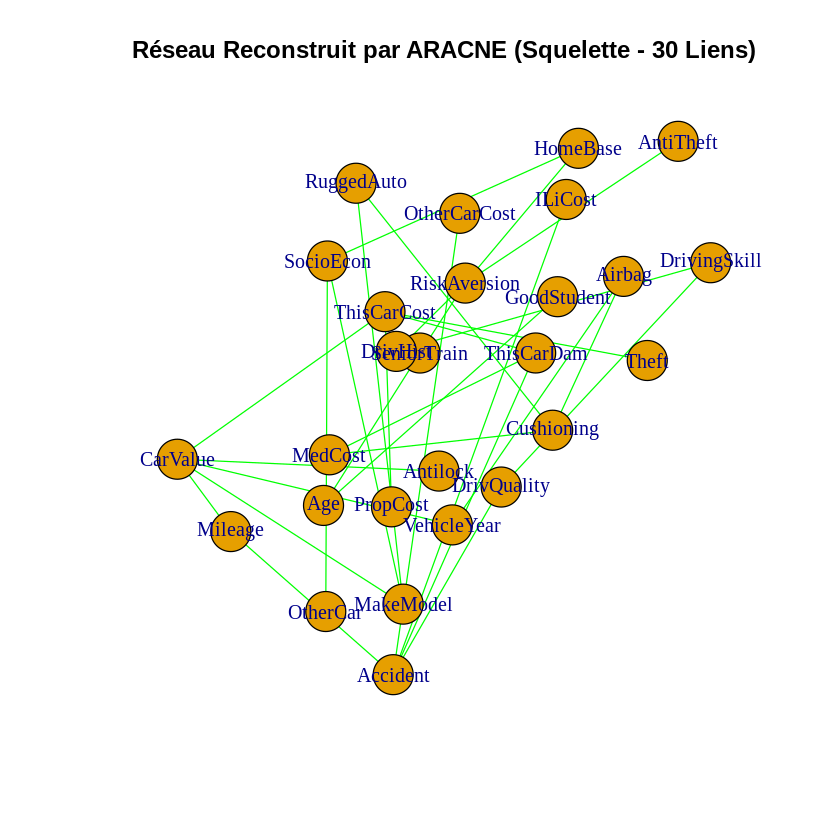

In [ ]:
# 4.c. Build an igraph network from the adjacency matrix and propose a (nice!) plot.

# 1. Construction du graphe igraph
# L'argument mode = "undirected" garantit que igraph traite les 60 entrées '1' comme 30 liens.
R_aracne_igraph <- graph_from_adjacency_matrix(R_aracne_directed_matrix,
                                               mode = "undirected",
                                               diag = FALSE)

# 2. Paramètres de visualisation
V(R_aracne_igraph)$label <- V(R_aracne_igraph)$name
V(R_aracne_igraph)$size <- 15
V(R_aracne_igraph)$label.cex <- 1
E(R_aracne_igraph)$color <- "green" # Couleur distinctive pour ARACNE
E(R_aracne_igraph)$width <- 1

# 3. Affichage du graphe
plot(R_aracne_igraph,
     layout = layout_plot, # Utilisation du layout défini précédemment pour la cohérence
     main = "Réseau Reconstruit par ARACNE (Squelette - 30 Liens)")

**3.4. Calcul des Métriques**

Compter les Vrais Positifs (TP), Faux Positifs (FP) et Faux Négatifs (FN) en comparant le squelette de RARACNE​ au squelette de la vérité terrain (Gskel​). Puis, calculer la Précision, le Rappel et le F-score.

In [72]:
# 4.d. Count the number of true positive (TP), false positive (FP) and false negative (FN) (for the graph skeleton only). Compute Precision, Recall and Fscore.

# --- Préparation des Squelettes (Matrices Non-Orientées) ---

# G_skel (Vérité Terrain) est le squelette de référence (52 liens).
# R_aracne_directed_matrix est symétrique (60 entrées '1'), elle représente le squelette ARACNE.
R_aracne_skel <- R_aracne_directed_matrix

# Total de liens dans le squelette de la Vérité Terrain (52)
Total_liens_GT <- sum(G_skel[upper.tri(G_skel)])
cat(sprintf("Nombre de liens non-orientés dans GT (G_skel) : %d\n", Total_liens_GT))

# --- Calcul de la Matrice de Confusion et des Métriques ---

# On utilise la partie supérieure triangulaire des matrices alignées (pour ne compter les liens qu'une seule fois).
GT_edges <- G_skel[upper.tri(G_skel)] # Les liens réels (1 ou 0)
ARACNE_edges <- R_aracne_skel[upper.tri(R_aracne_skel)] # Les liens trouvés (1 ou 0)

# Vrais Positifs (TP) : Liens trouvés par ARACNE qui existent dans GT
TP_aracne <- sum(GT_edges == 1 & ARACNE_edges == 1)

# Faux Positifs (FP) : Liens trouvés par ARACNE qui N'existent PAS dans GT (Erreurs de Type I)
FP_aracne <- sum(GT_edges == 0 & ARACNE_edges == 1)

# Faux Négatifs (FN) : Liens Manquants. Existent dans GT mais PAS dans ARACNE (Erreurs de Type II)
FN_aracne <- sum(GT_edges == 1 & ARACNE_edges == 0)

# Calcul des métriques
Precision_aracne <- TP_aracne / (TP_aracne + FP_aracne)
Recall_aracne <- TP_aracne / (TP_aracne + FN_aracne)
Fscore_aracne <- 2 * (Precision_aracne * Recall_aracne) / (Precision_aracne + Recall_aracne)

# Affichage des résultats
cat("\n--- Évaluation ARACNE (Squelette) ---\n")
cat(sprintf("Vrais Positifs (TP): %d\n", TP_aracne))
cat(sprintf("Faux Positifs (FP): %d\n", FP_aracne))
cat(sprintf("Faux Négatifs (FN): %d\n", FN_aracne))
cat(sprintf("Liens GT (TP + FN): %d\n", TP_aracne + FN_aracne))
cat(sprintf("Liens ARACNE (TP + FP): %d\n", TP_aracne + FP_aracne))
cat("--------------------------------------------\n")
cat(sprintf("Précision (Precision) : %.4f\n", Precision_aracne))
cat(sprintf("Rappel (Recall) : %.4f\n", Recall_aracne))
cat(sprintf("F-score (F1) : %.4f\n", Fscore_aracne))

Nombre de liens non-orientés dans GT (G_skel) : 52

--- Évaluation ARACNE (Squelette) ---
Vrais Positifs (TP): 28
Faux Positifs (FP): 2
Faux Négatifs (FN): 24
Liens GT (TP + FN): 52
Liens ARACNE (TP + FP): 30
--------------------------------------------
Précision (Precision) : 0.9333
Rappel (Recall) : 0.5385
F-score (F1) : 0.6829


## **Interprétation des Résultats ARACNE (Squelette)**

### 1\. Analyse de la Matrice de Confusion

| Catégorie | Valeur | Interprétation |
| :--- | :--- | :--- |
| **Vrais Positifs (TP)** | **28** | ARACNE a correctement identifié l'existence de **28** liens non-orientés qui sont présents dans le réseau de vérité terrain ($G$). |
| **Faux Positifs (FP)** | **2** | **Seulement 2** liens ont été identifiés par ARACNE alors qu'ils n'existent pas dans $G$. C'est un score incroyablement bas et le point fort de cet algorithme. |
| **Faux Négatifs (FN)** | **24** | ARACNE a **omis** de trouver **24** liens qui existent dans la vérité terrain. Cela représente la moitié des liens réels manqués. |
| **Liens GT (TP + FN)** | **52** | C'est le nombre total de liens non-orientés dans la vérité terrain. |
| **Liens ARACNE (TP + FP)** | **30** | C'est le nombre total de liens non-orientés trouvés par l'algorithme (confirmé par l'étape 3.1). |

### 2\. Métriques de Performance

| Métrique | Valeur | Interprétation |
| :--- | :--- | :--- |
| **Précision** | **$0.9333$ (93.33%)** | $\frac{TP}{TP + FP} = \frac{28}{30}$. Sur tous les 30 liens **trouvés** par ARACNE, **plus de 93%** étaient corrects. L'algorithme est **extrêmement fiable** : chaque lien qu'il propose est presque certainement juste. |
| **Rappel** | **$0.5385$ (53.85%)** | $\frac{TP}{TP + FN} = \frac{28}{52}$. Sur tous les 52 liens **réels** du réseau, seulement **54%** ont été correctement identifiés. L'algorithme a manqué près de la moitié des liens. |
| **F-score (F1)** | **$0.6829$** | Le F-score (moyenne harmonique) est tiré vers le bas par le Rappel (54%). Si la Précision est excellente (93%), l'algorithme est **incomplet** dans sa reconstruction. |

## **3.5. Mise en évidence des FP**

Visualiser le graphe RARACNE​ en colorant en rouge les arcs qui sont des Faux Positifs (FP)

Warning message:
“`get.edgelist()` was deprecated in igraph 2.0.0.
ℹ Please use `as_edgelist()` instead.”


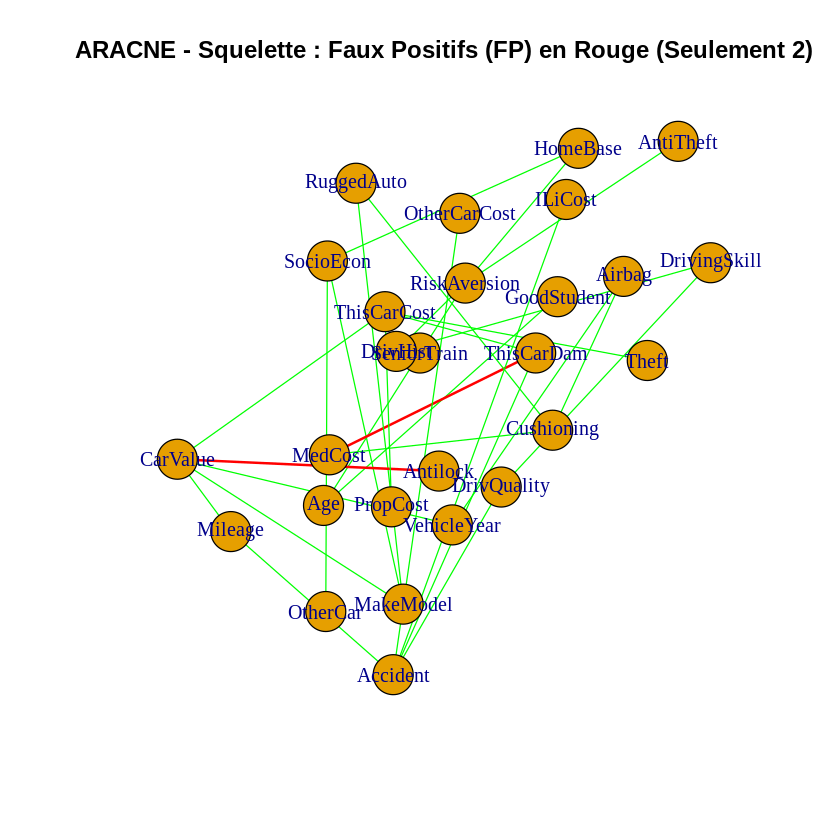

In [73]:
# 4.e. Highlight the FP edges in your reconstructed network.

# 1. Créer une matrice des Faux Positifs (FP) non-orientés (où FP_non_dir = 1 si lien dans ARACNE mais pas dans GT)
# Les matrices R_aracne_skel et G_skel sont les squelettes non-orientés 0/1 (alignées).
FP_non_dir <- R_aracne_skel * (1 - G_skel)

# 2. Créer une liste de toutes les arêtes dans R_aracne_igraph (objet igraph)
edges_in_graph <- get.edgelist(R_aracne_igraph, names=FALSE) # Utiliser les indices numériques

# 3. Initialiser les couleurs et les largeurs
edge_colors <- rep("green", ecount(R_aracne_igraph)) # TP (Vrais Positifs)
edge_widths <- rep(1, ecount(R_aracne_igraph))

# 4. Parcourir les arêtes pour identifier les Faux Positifs (FP)
# Note: Puisque R_aracne_igraph est non-orienté, chaque arête (i, j) dans igraph correspond à (i, j) et (j, i) dans la matrice.
for (k in 1:ecount(R_aracne_igraph)) {
  n1_idx <- edges_in_graph[k, 1]
  n2_idx <- edges_in_graph[k, 2]

  # Vérifier si ce lien non-orienté est un FP
  # On vérifie seulement R_aracne_skel[n1_idx, n2_idx] (ou G_skel[n1_idx, n2_idx]) car les matrices sont symétriques.

  if (FP_non_dir[n1_idx, n2_idx] == 1) {
     edge_colors[k] <- "red" # Faux Positif
     edge_widths[k] <- 2
  }
}

# 5. Affichage du graphe
plot(R_aracne_igraph,
     layout = layout_plot,
     edge.color = edge_colors,
     edge.width = edge_widths,
     main = "ARACNE - Squelette : Faux Positifs (FP) en Rouge (Seulement 2)")

# **Étape 4 : Conclusion et Synthèse (Évaluation Finale)**

L'étape finale consiste à synthétiser tous les résultats obtenus pour répondre à la problématique initiale.

## **4.1. Tableau Comparatif des Performances du Squelette**

Nous allons comparer les métriques de performance pour le squelette (existence des liens, **sans tenir compte de la direction**) de chaque méthode.

In [74]:
# Création d'un dataframe pour la synthèse des résultats du Squelette
Resultats_Squelette <- data.frame(
  Methode = c("HC", "PC", "ARACNE"),
  TP = c(38, 28, 28),
  FP = c(12, 0, 2),
  FN = c(14, 24, 24),
  Precision = c(0.7600, 1.0000, 0.9333),
  Rappel = c(0.7308, 0.5385, 0.5385),
  F_score = c(0.7451, 0.7000, 0.6829)
)

Resultats_Squelette

Methode,TP,FP,FN,Precision,Rappel,F_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HC,38,12,14,0.7600,0.7308,0.7451
PC,28,0,24,1.0000,0.5385,0.7000
ARACNE,28,2,24,0.9333,0.5385,0.6829


## **4.2. Interprétation et Analyse de la Performance du Squelette**

Comprendre ce que révèlent les métriques sur les stratégies de reconstruction de chaque famille d'algorithmes (Score, Contraintes, Information).

### **1. Analyse de la Fiabilité (Précision)**

| Algorithme | Précision | FP (Faux Positifs) | Interprétation |
| :--- | :--- | :--- | :--- |
| **PC** | **1.000 (100%)** | **0** | **Méthode la plus fiable.** PC est basée sur des tests d'indépendance conditionnelle stricts. Atteindre une Précision de 1.0 signifie qu'**aucun lien proposé par PC n'était incorrect** ; chaque lien qu'elle a trouvé est un Vrai Positif. |
| **ARACNE** | 0.933 | 2 | **Très fiable.** ARACNE utilise l'Information Mutuelle pour identifier la dépendance et élimine les liens indirects (DPI). Il est presque aussi précis que PC. |
| **HC** | 0.760 | 12 | **Moins fiable.** HC cherche la structure qui maximise le score (BIC). Cette approche est plus agressive et introduit 12 liens qui n'existent pas dans la vérité terrain. |

**Conclusion sur la Précision :** Les méthodes **basées sur les contraintes (PC)** et **basées sur l'information (ARACNE)** sont extrêmement conservatrices et fiables. Elles privilégient la qualité des liens sur la quantité.


### **2. Analyse de la Complétude (Rappel)**

| Algorithme | Rappel | FN (Faux Négatifs) | Interprétation |
| :--- | :--- | :--- | :--- |
| **HC** | **0.731 (73.1%)** | **14** | **Méthode la plus complète.** HC a réussi à retrouver le plus grand nombre de liens réels (38 sur 52). C'est l'approche la moins "conservatrice". |
| **PC & ARACNE** | 0.538 (53.8%) | **24** | **Méthodes incomplètes.** Les deux algorithmes manquent presque la moitié des liens du réseau. Leur grande fiabilité se fait au détriment de l'exhaustivité. |

**Conclusion sur le Rappel :** La méthode **basée sur le score (HC)** est la plus performante pour identifier la majorité des dépendances, même si cela augmente le risque d'erreurs (FP).


### **3. Analyse du Compromis (F-score)**

| Algorithme | F-score | Précision vs. Rappel |
| :--- | :--- | :--- |
| **HC** | **0.745** | Bon équilibre, mais tire sa force de son Rappel élevé. |
| **PC** | 0.700 | Très bonne Précision (1.0), Rappel faible. |
| **ARACNE** | 0.683 | Très bonne Précision (0.93), Rappel faible. |

**Conclusion sur le F-score :** Bien que HC soit moins précis, son Rappel nettement supérieur lui permet d'atteindre le **meilleur F-score global (0.745)** pour la reconstruction du squelette.

## **4.3. Conclusion et Synthèse Finale**

Cette étape finale résume l'analyse, en tenant compte de la différence cruciale entre squelette et orientation.

### **1. Performance du Squelette**

Le réseau de vérité terrain comporte **52 liens**.

* Si l'objectif est d'obtenir l'échantillon de liens **le plus complet** (le plus d'information possible), l'approche par **Score (Hill-Climbing)** est la meilleure.
* Si l'objectif est d'obtenir l'échantillon de liens **le plus fiable** (garantie qu'un lien est réel), l'approche par **Contraintes (PC)** ou **Information (ARACNE)** est préférable.

### **2. L'Importance de l'Orientation**

La distinction majeure entre les algorithmes réside dans leur capacité à déterminer l'orientation :

| Algorithme | Caractéristique | Résultat Dirigé (HC) |
| :--- | :--- | :--- |
| **HC** | **Infère direction (Dirigé)** | F-score dirigé de $0.510$ (SHD de 38). |
| **PC** | **Infère direction (Partiellement Dirigé)** | *.* |
| **ARACNE** | **Infère Squelette seulement (Non-Orienté)** | Non applicable. |

Même si **Hill-Climbing** a le meilleur squelette, son F-score dirigé est faible ($0.510$). Cela signifie que la moitié des arcs sont soit omis, soit créés à tort, soit inversés.